# Download dataset

In [ ]:
!kaggle datasets download -d ramjasmaurya/poem-classification-nlp

Dataset URL: https://www.kaggle.com/datasets/ramjasmaurya/poem-classification-nlp
License(s): CC0-1.0
100% 120k/120k [00:00<00:00, 550kB/s]
100% 120k/120k [00:00<00:00, 549kB/s]


In [ ]:
!mkdir /content/dataset

In [ ]:
!unzip /content/poem-classification-nlp.zip -d /content/dataset

Archive:  /content/poem-classification-nlp.zip
  inflating: /content/dataset/Poem_classification - test_data.csv  
  inflating: /content/dataset/Poem_classification - train_data.csv  


# Import liberaries

In [ ]:
!pip install transformers datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.metrics import (classification_report, confusion_matrix,
      accuracy_score, roc_curve)
from sklearn.preprocessing import (LabelEncoder, StandardScaler,
                    MinMaxScaler, RobustScaler, Normalizer)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
          VotingClassifier, AdaBoostClassifier)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.metrics import (Precision, Recall, Accuracy, TopKCategoricalAccuracy,
                                  CategoricalAccuracy, SparseCategoricalAccuracy)
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense, ReLU, Embedding, BatchNormalization,
                                     Conv1D, GlobalMaxPooling1D, Dropout,
                                     LSTM, Bidirectional,
                                     Flatten, InputLayer, Input, LayerNormalization)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow as tf

from transformers import (BertTokenizerFast, TFBertForSequenceClassification,
              TFBertModel, create_optimizer)

from tqdm import tqdm, trange, tnrange, tqdm_notebook

In [ ]:
sns.set(font_scale=1.3)

In [ ]:
!python -m nltk.downloader all

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/

# Load datasests

In [ ]:
# Read datasets
df_train = pd.read_csv('/content/dataset/Poem_classification - train_data.csv')
df_test = pd.read_csv('/content/dataset/Poem_classification - test_data.csv')

In [ ]:
df_train.head()

,Genre,Poem
0,Music,NaN
1,Music,In the thick brushthey spend the...
2,Music,Storms are generous. ...
3,Music,—After Ana Mendieta Did you carry around the ...
4,Music,for Aja Sherrard at 20The portent may itself ...


In [ ]:
df_train.shape

(841, 2)

In [ ]:
df_test.shape

(150, 2)

# Assessing

## Train dataset

In [ ]:
# See one example of 'Poem' from train dataframe
df_train.iloc[1]['Poem']

'\xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 In the thick brushthey spend the hottest part of the day,\xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 soaking their hoovesin the trickle of mountain water\xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 the ravine hoardson behalf of the oleander.\xa0 \xa0 \xa0 \xa0 \xa0 \xa0'

In [ ]:
# Check if the data is balanced or not
df_train.Genre.value_counts()

,count
Genre,
Music,239
Death,234
Environment,227
Affection,141


In [ ]:
# Check if the data is balanced or not
df_train.Genre.value_counts() / df_train.shape[0] * 100

,count
Genre,
Music,28.418549
Death,27.824019
Environment,26.991677
Affection,16.765755


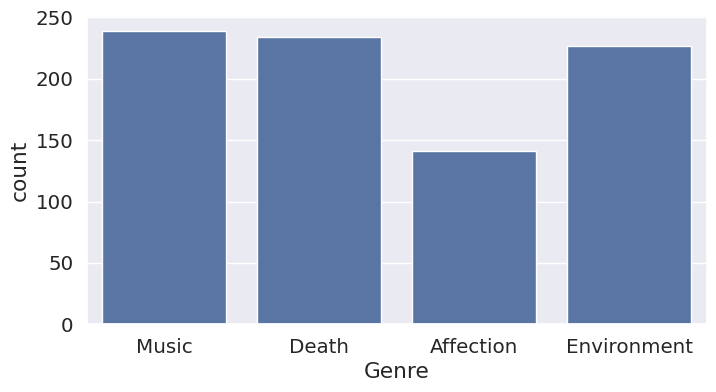

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Genre', data=df_train);

It's seem or data is balanced

In [ ]:
# Print the number of null values in each column
df_train.isnull().sum()

,0
Genre,0
Poem,4


In [ ]:
# Remove null values
df_train.dropna(inplace=True)
df_train.reset_index(inplace=True, drop=True)

In [ ]:
# Print the number of duplicated values
df_train.duplicated().sum()

2

There is just one row which is duplicated but we need to check also if there are rows having the same text but different emotions

In [ ]:
# Removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis=0, inplace=True)
df_train.reset_index(inplace=True, drop=True)

In [ ]:
# Print the rows which are duplicated(duplicated in poem but with different emotions)
df_train[df_train['Poem'].duplicated() == True]

,Genre,Poem
255,Death,{on the occasion of Martin Puryear’s Noblesse ...
277,Death,And after the black boy is strangled by police...
295,Death,Everything in the beginning is the same. Cloud...
299,Death,for my grandfatherWe don’t have heirlooms. Hav...
313,Death,How is it you bring me back to the cliffs th...
339,Death,I was trying to wave to you but you wouldn’t w...
345,Death,I'm few deja-vus from repeating my whole life ...
367,Death,"My brother, wanting to off himself, Took rope ..."
374,Death,"New moon in midheaven, in Libra. The hermit wi..."
392,Death,Shame on you for dating a museum:Everything is...


In [ ]:
# Print some of those rows to check
df_train[df_train['Poem'] == df_train.iloc[829]['Poem']]

,Genre,Poem
596,Affection,Who would decry instruments— when grasses ever...
829,Environment,Who would decry instruments— when grasses ever...


In [ ]:
# Removing duplicated text
index = df_train[df_train['Poem'].duplicated() == True].index
df_train.drop(index, axis=0, inplace=True)
df_train.reset_index(inplace=True, drop=True)

In [ ]:
# Count the number of stopwords in the data
temp = df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Poem'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

,count
stop_words,
12,85
10,83
13,80
11,68
14,65
15,63
9,48
16,46
7,44


<Axes: ylabel='Frequency'>

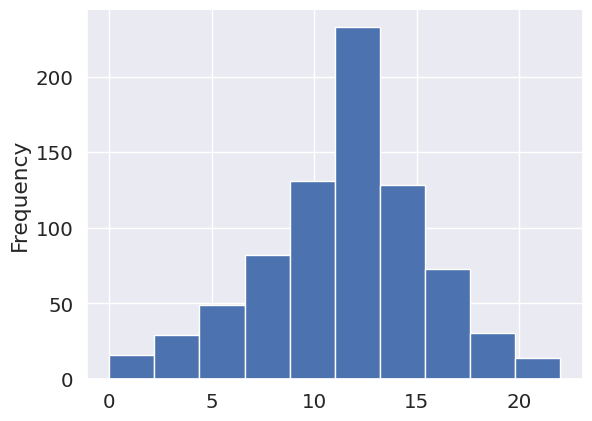

In [ ]:
# Distribution of stopwords visualy
temp['stop_words'].plot(kind='hist')

## Test dataset

In [ ]:
# Check if the data is balanced or not
df_test.Genre.value_counts()

,count
Genre,
Affection,100
Environment,25
Death,13
Music,12


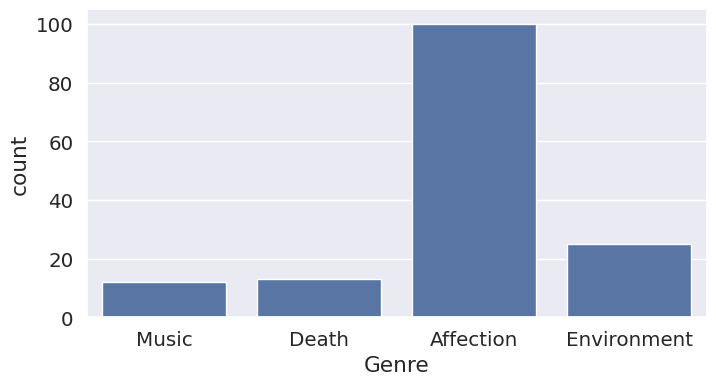

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='Genre', data=df_test);

In [ ]:
# Print the number of null values in each column
df_test.isnull().sum()

,0
Genre,0
Poem,0


In [ ]:
# Print the number of duplicated values
df_test.duplicated().sum()

0

In [ ]:
# Print the rows which are duplicated
df_test[df_test['Poem'].duplicated() == True]

,Genre,Poem


In [ ]:
# Count the number of stopwords in the data
temp = df_test.copy()
temp['stop_words'] = temp['Poem'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

,count
stop_words,
11,20
14,17
12,16
9,16
15,14
10,13
13,12
17,7
18,6


<Axes: ylabel='Frequency'>

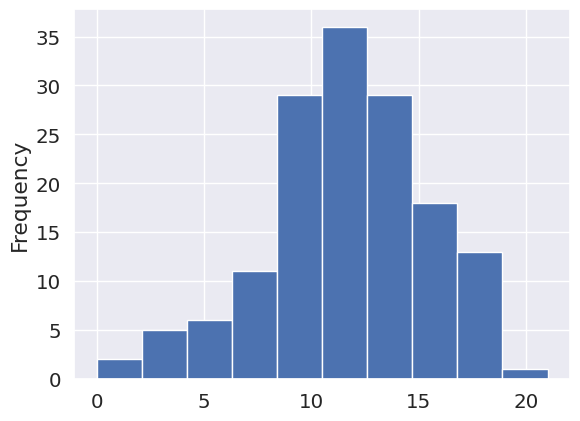

In [ ]:
temp['stop_words'].plot(kind='hist')

## Compare rows of the datasets

Check that is no data leakage

In [ ]:
def dataframe_difference(df1, df2, which=None):
  """Find rows which are different between two DataFrames."""

  comparison_df = df1.merge(
      df2,
      indicator=True,
      how='outer'
  )

  if which is None:
    diff_df = comparison_df[comparison_df['_merge'] != 'both']
  else:
    diff_df = comparison_df[comparison_df['_merge'] == which]
  return diff_df

In [ ]:
train_test_diff = dataframe_difference(df_train, df_test, which='both')

In [ ]:
# Remove datalekaged from train dataset
for _, data in train_test_diff.iterrows():
  index = df_train[df_train['Poem'] == data[1]].index
  df_train.drop(index, axis=0, inplace=True)
df_train.reset_index(inplace=True, drop=True)

<ipython-input-15-4615b45a9f86>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  index = df_train[df_train['Poem'] == data[1]].index


## Cleaning

In [ ]:
def convert_to_space(text):
  cleaned_text = text.replace('\xa0', ' ')
  return cleaned_text

def lemmatization(text):
  lemmatizer = WordNetLemmatizer()

  text = text.split()

  text = [lemmatizer.lemmatize(y) for y in text]

  return " ".join(text)

def remove_stop_words(text):
  Text=[i for i in str(text).split() if i not in stop_words]
  return " ".join(Text)

def Removing_numbers(text):
  text=''.join([i for i in text if not i.isdigit()])
  return text

def lower_case(text):
  text = text.split()
  text=[y.lower() for y in text]
  return " ".join(text)

def Removing_punctuations(text):
  # Remove punctuations
  text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
  text = text.replace(';', "", )

  # remove extra whitespace
  text = re.sub('\s', ' ', text)
  text = " ".join(text.split())
  return text.strip()

def Removing_urls(text):
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  return url_pattern.sub(r'', text)

def remove_small_sentences(df):
  for i in range(len(df)):
    if len(df.text.iloc[i].split()) < 3:
      df.text.iloc[i] = np.nan
def normalized_sentence(sentence):
  sentence = convert_to_space(sentence)
  sentence = lower_case(sentence)
  sentence = remove_stop_words(sentence)
  sentence = Removing_numbers(sentence)
  sentence = Removing_punctuations(sentence)
  sentence = Removing_urls(sentence)
  sentence = lemmatization(sentence)
  return sentence

In [ ]:
normalized_sentence(df_train.iloc[2]['Poem'])

'—after ana mendieta carry around matin star hold forest fire one hand would wake radiate shimmer gleam lucero light morning would measure wingspan idea taking off— night would'

In [ ]:
class TextProcessor(BaseEstimator, TransformerMixin):
  def __init__(self, lower=False, lemma=False, to_space=False,
    punct=False, stop_word=False, number=False, urls=False):
    self.lower = lower
    self.lemma = lemma
    self.to_space = to_space
    self.punct = punct
    self.stop_word = stop_word
    self.number = number
    self.urls = urls
    super().__init__()
  def fit(self, X, y=None):
    return self
  def __convert_to_space(self, text):
    cleaned_text = text.replace('\xa0', ' ')
    return cleaned_text

  def __lemmatization(self, text):
    lemmatizer = WordNetLemmatizer()

    text = text.split()

    text = [lemmatizer.lemmatize(y) for y in text]

    return " ".join(text)

  def __remove_stop_words(self, text):
    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

  def __Removing_numbers(self, text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

  def __lower_case(self, text):
    text = text.split()
    text=[y.lower() for y in text]
    return " ".join(text)

  def __Removing_punctuations(self, text):
    # Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace(';', "", )

    # remove extra whitespace
    text = re.sub('\s', ' ', text)
    text = " ".join(text.split())
    return text.strip()

  def __Removing_urls(self, sentence):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', sentence)
  def text_processing(self, sentence):
    if self.to_space:
      sentence = self.__convert_to_space(sentence)
    if self.lower:
      sentence = self.__lower_case(sentence)
    if self.stop_word:
      sentence = self.__remove_stop_words(sentence)
    if self.number:
      sentence = self.__Removing_numbers(sentence)
    if self.punct:
      sentence = self.__Removing_punctuations(sentence)
    if self.urls:
      sentence = self.__Removing_urls(sentence)
    if self.lemma:
      sentence = self.__lemmatization(sentence)
    return sentence


  def transform(self, X):
    return [self.text_processing(sentence) for sentence in X]

# Modeling

## Preprocessing

In [ ]:
text_processor = TextProcessor(lower=True, lemma=True, to_space=True,
        punct=True, stop_word=True, number=True, urls=True)
vectorizer = CountVectorizer(max_features=3000)

## RandomForestClassifier

In [ ]:
RF = RandomForestClassifier(
    n_estimators=50, random_state=42, n_jobs=-1, verbose=1
)

pipeline = Pipeline([
    ("text_preprocessing", text_processor),
    ("vectorizer", CountVectorizer()),
    ("classifier", RF)
])

pipeline.fit(df_train['Poem'], df_train['Genre'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


Pipeline(steps=[('text_preprocessing',
                 TextProcessor(lemma=True, lower=True, number=True, punct=True,
                               stop_word=True, to_space=True, urls=True)),
                ('vectorizer', CountVectorizer()),
                ('classifier',
                 RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                        random_state=42, verbose=1))])


### In the following code block, we preprocess the text data for training, testing, and validation datasets to ensure that the data frames are formatted correctly, facilitating accurate predictions.

In [ ]:
process_pip = Pipeline(
    [
        ("text_processing", text_processor)
    ]
)

x_train_procceced = process_pip.fit_transform(df_train['Poem'])
x_test_procceced = process_pip.transform(df_test['Poem'])

### Predict and evaluate model

In [ ]:
# Train set accuracy
train_pred = pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(df_train['Genre'], train_pred)
print('Train set accuracy: ', train_accuracy)

# Test set accuracy
test_pred = pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(df_test['Genre'], test_pred)
print("Test set accuracy: ", test_accuracy)

RF_acc = test_accuracy

Train set accuracy:  0.9923469387755102
Test set accuracy:  0.18


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


## SVC

In [ ]:
text_processor = TextProcessor(lower=True, lemma=True, to_space=True,
        punct=True, stop_word=True, number=True, urls=True)
vectorizer = CountVectorizer(max_features=3000)

svm = SVC(kernel="linear", gamma=1, C=5, random_state=42)
svm_pipeline = Pipeline(
    [
        ("text_processing", text_processor),
        ("vectorizer", vectorizer),
        ("svm", svm)
    ]
)

svm_pipeline.fit(df_train['Poem'], df_train['Genre'])

Pipeline(steps=[('text_processing',
                 TextProcessor(lemma=True, lower=True, number=True, punct=True,
                               stop_word=True, to_space=True, urls=True)),
                ('vectorizer', CountVectorizer(max_features=3000)),
                ('svm', SVC(C=5, gamma=1, kernel='linear', random_state=42))])

In [ ]:
# Train set accuracy
train_pred = svm_pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(df_train['Genre'], train_pred)
print('Train set accuracy: ', train_accuracy)

# Test set accuracy
test_pred = svm_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(df_test['Genre'], test_pred)
print("Test set accuracy: ", test_accuracy)

svm_acc = test_accuracy

Train set accuracy:  0.9974489795918368
Test set accuracy:  0.22666666666666666


## LogisticRegression

In [ ]:
text_processor = TextProcessor(lower=True, lemma=True, to_space=True,
        punct=True, stop_word=True, number=True, urls=True)
vectorizer = CountVectorizer(max_features=3000)

logistics = LogisticRegression(random_state=42, max_iter=1000)

logs_pipeline = Pipeline([
    ("text_processing", text_processor),
    ("vectorizer", vectorizer),
    ("classifier", logistics)
])

logs_pipeline.fit(df_train['Poem'], df_train['Genre'])

Pipeline(steps=[('text_processing',
                 TextProcessor(lemma=True, lower=True, number=True, punct=True,
                               stop_word=True, to_space=True, urls=True)),
                ('vectorizer', CountVectorizer(max_features=3000)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [ ]:
# Train set accuracy
train_pred = logs_pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(df_train['Genre'], train_pred)
print('Train set accuracy: ', train_accuracy)

# Test set accuracy
test_pred = logs_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(df_test['Genre'], test_pred)
print("Test set accuracy: ", test_accuracy)

logs_acc = test_accuracy

Train set accuracy:  0.9961734693877551
Test set accuracy:  0.26666666666666666


## NaiveBayes

In [ ]:
text_processor = TextProcessor(lower=True, lemma=True, to_space=True,
        punct=True, stop_word=True, number=True, urls=True)
vectorizer = CountVectorizer(max_features=3000)

MNB = MultinomialNB()

MNB_pipeline = Pipeline([
    ("text_processing", text_processor),
    ("vectorizer", vectorizer),
    ("classifier", MNB)
])

MNB_pipeline.fit(df_train['Poem'], df_train['Genre'])

Pipeline(steps=[('text_processing',
                 TextProcessor(lemma=True, lower=True, number=True, punct=True,
                               stop_word=True, to_space=True, urls=True)),
                ('vectorizer', CountVectorizer(max_features=3000)),
                ('classifier', MultinomialNB())])

In [ ]:
# Train set accuracy
train_pred = MNB_pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(df_train['Genre'], train_pred)
print('Train set accuracy: ', train_accuracy)

# Test set accuracy
test_pred = MNB_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(df_test['Genre'], test_pred)
print("Test set accuracy: ", test_accuracy)

MNB_acc = test_accuracy

Train set accuracy:  0.9566326530612245
Test set accuracy:  0.26


## GradientBoostingClassifier

In [ ]:
text_processor = TextProcessor(lower=True, lemma=True, to_space=True,
        punct=True, stop_word=True, number=True, urls=True)
vectorizer = CountVectorizer(max_features=3000)

GB = GradientBoostingClassifier()

GB_pipeline = Pipeline([
    ("text_processing", text_processor),
    ("vectorizer", vectorizer),
    ("classifier", GB)
])

GB_pipeline.fit(df_train['Poem'], df_train['Genre'])

Pipeline(steps=[('text_processing',
                 TextProcessor(lemma=True, lower=True, number=True, punct=True,
                               stop_word=True, to_space=True, urls=True)),
                ('vectorizer', CountVectorizer(max_features=3000)),
                ('classifier', GradientBoostingClassifier())])

In [ ]:
# Train set accuracy
train_pred = GB_pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(df_train['Genre'], train_pred)
print('Train set accuracy: ', train_accuracy)

# Test set accuracy
test_pred = GB_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(df_test['Genre'], test_pred)
print("Test set accuracy: ", test_accuracy)

GB_acc = test_accuracy

Train set accuracy:  0.8877551020408163
Test set accuracy:  0.32


## Best Model Implementation


### The code segment creates a bar plot to visualize the accuracies of different machine learning models.

<ipython-input-49-6f071743e698>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=model_names, y=accuracy_values, palette="YlGnBu")


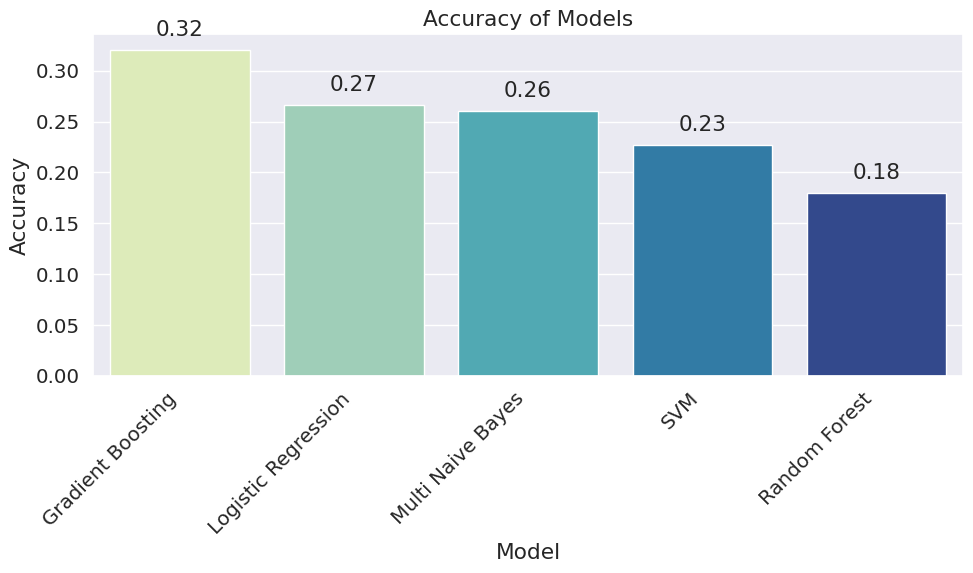

In [ ]:
accuracies = {
    "Multi Naive Bayes": MNB_acc,
    "SVM": svm_acc,
    "Random Forest": RF_acc,
    "Logistic Regression": logs_acc,
    "Gradient Boosting": GB_acc
}

# Sort accuracies in descending order
sorted_accuracies = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

# Extract model names and accuracies
model_names = [model[0] for model in sorted_accuracies]
accuracy_values = [model[1] for model in sorted_accuracies]

# Create countplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=model_names, y=accuracy_values, palette="YlGnBu")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy of Models")
plt.xticks(rotation=45, ha='right')

# Annotate each bar with is accuracy value
for i, v in enumerate(accuracy_values):
  ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ("GB", GB_pipeline),
    ("Logistic Regression", logs_pipeline),
    ("MNB", MNB_pipeline)
]

voting_classifier = VotingClassifier(estimators, voting='hard')
voting_classifier.fit(df_train['Poem'], df_train['Genre'])

VotingClassifier(estimators=[('GB',
                              Pipeline(steps=[('text_processing',
                                               TextProcessor(lemma=True,
                                                             lower=True,
                                                             number=True,
                                                             punct=True,
                                                             stop_word=True,
                                                             to_space=True,
                                                             urls=True)),
                                              ('vectorizer',
                                               CountVectorizer(max_features=3000)),
                                              ('classifier',
                                               GradientBoostingClassifier())])),
                             ('Logistic Regression',
                              Pipeline(steps=[('text_processing',
                                               TextProcessor(lemma=True,
                                                             l...
                                                             urls=True)),
                                              ('vectorizer',
                                               CountVectorizer(max_features=3000)),
                                              ('classifier',
                                               LogisticRegression(max_iter=1000,
                                                                  random_state=42))])),
                             ('MNB',
                              Pipeline(steps=[('text_processing',
                                               TextProcessor(lemma=True,
                                                             lower=True,
                                                             number=True,
                                                             punct=True,
                                                             stop_word=True,
                                                             to_space=True,
                                                             urls=True)),
                                              ('vectorizer',
                                               CountVectorizer(max_features=3000)),
                                              ('classifier',
                                               MultinomialNB())]))])

In [ ]:
# Train set accuracy
train_pred = voting_classifier.predict(x_train_procceced)
train_accuracy = accuracy_score(df_train['Genre'], train_pred)
print('Train set accuracy: ', train_accuracy)

# Test set accuracy
test_pred = voting_classifier.predict(x_test_procceced)
test_accuracy = accuracy_score(df_test['Genre'], test_pred)
print("Test set accuracy: ", test_accuracy)

model_accuracy = test_accuracy

Train set accuracy:  0.9846938775510204
Test set accuracy:  0.2866666666666667


# Using LSTM

## Text Preprocessing

In [ ]:
text_processor = TextProcessor(lower=True, lemma=True, to_space=True,
        punct=True, stop_word=True, number=True, urls=True)

In [ ]:
process_pip = Pipeline(
    [
        ("text_processing", text_processor)
    ]
)

x_train = process_pip.fit_transform(df_train['Poem'])
y_train = df_train['Genre']

x_test = process_pip.transform(df_test['Poem'])
y_test = df_test['Genre']

In [ ]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
# Print the labels after encoding
print(set(y_train))

{0, 1, 2, 3}


In [ ]:
# Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
print(y_train)

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


## Tokenizing

In [ ]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([pd.Series(x_train), pd.Series(x_test)], axis=0))

In [ ]:
#document count: A dictionary of words and how many documents each appeared in.
#in this dataset the output will be the number of rows
tokenizer.document_count

934

In [ ]:
# Print the index of a single word
tokenizer.word_index['towards']

5725

In [ ]:
# Convert a single sentence to list of indexes
tokenizer.texts_to_sequences(x_train[0].split())

[[486],
 [2963],
 [1309],
 [1791],
 [320],
 [8],
 [1792],
 [2964],
 [1041],
 [189],
 [42],
 [1793],
 [2965],
 [2966],
 [2967]]

In [ ]:
sentence_train = tokenizer.texts_to_sequences(x_train)
sentence_test = tokenizer.texts_to_sequences(x_test)

## Padding

In [ ]:
df_test.shape

(150, 2)

In [ ]:
maxlen = max([len(t) for t in df_train['Poem']])
maxlen

469

In [ ]:
x_train = pad_sequences(sentence_train, maxlen=469, truncating='pre')
x_test = pad_sequences(sentence_test, maxlen=469, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 8848


In [ ]:
# Before
sentence_train[0]

[486,
 2963,
 1309,
 1791,
 320,
 8,
 1792,
 2964,
 1041,
 189,
 42,
 1793,
 2965,
 2966,
 2967]

In [ ]:
# After
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Word Embedding

In [ ]:
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation

Dataset URL: https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation
License(s): other
100% 458M/458M [00:17<00:00, 38.4MB/s]
100% 458M/458M [00:17<00:00, 27.2MB/s]


In [ ]:
!mkdir /content/glove-global-vectors-for-word-representation

In [ ]:
!unzip /content/glove-global-vectors-for-word-representation.zip -d /content/glove-global-vectors-for-word-representation

Archive:  /content/glove-global-vectors-for-word-representation.zip
  inflating: /content/glove-global-vectors-for-word-representation/glove.6B.100d.txt  
  inflating: /content/glove-global-vectors-for-word-representation/glove.6B.200d.txt  
  inflating: /content/glove-global-vectors-for-word-representation/glove.6B.50d.txt  


In [ ]:
# Reade GloVE embeddings
path_to_glove_file = '/content/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

In [ ]:
# Read word vectors
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 6470 words (2377 misses)


## Modeling

In [ ]:
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=x_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       1,769,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,769,600 (6.75 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,769,600 (6.75 MB)

In [ ]:
# To stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

In [ ]:
# Fit model
history = model.fit(
    x_train,
    y_train,
    verbose=1,
    batch_size=256,
    epochs=30,
    callbacks=[callback]
)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 172s 33s/step - accuracy: 0.2911 - loss: 1.5070
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 182s 31s/step - accuracy: 0.2777 - loss: 1.6855
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 159s 38s/step - accuracy: 0.3717 - loss: 1.3724
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 189s 34s/step - accuracy: 0.4332 - loss: 1.2783
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 197s 32s/step - accuracy: 0.4639 - loss: 1.1983
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 138s 32s/step - accuracy: 0.4742 - loss: 1.3067
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 140s 31s/step - accuracy: 0.5332 - loss: 1.1379
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 147s 32s/step - accuracy: 0.5546 - loss: 1.1042
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 143s 33s/step - accuracy: 0.5149 - loss: 1.1553
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 136s 31s/step - accuracy: 0.5725 - loss: 1.0578
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 150s 31s/step - accuracy: 0.5248 - loss: 1.1397
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 202s 33s/step - accuracy: 0.5975 - loss: 1.0177
Epoch 13/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 199s 32s/step - accuracy: 0.5572 - loss: 1.1084

In [ ]:
model.evaluate(x_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.3186 - loss: 2.2441


[2.3121378421783447, 0.2800000011920929]

# Transformers

## Text Preporcessing

In [ ]:
text_processor = TextProcessor(lower=True, lemma=True, to_space=True,
        punct=True, stop_word=True, number=True, urls=True)

In [ ]:
process_pip = Pipeline(
    [
        ("text_processing", text_processor)
    ]
)

x_train = process_pip.fit_transform(df_train['Poem'])
y_train = df_train['Genre']

x_test = process_pip.transform(df_test['Poem'])
y_test = df_test['Genre']

In [ ]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
# Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Put it into dataset

In [ ]:
dict1 = {'text': x_train, 'label': list(y_train)}
dict2 = {'text': x_test, 'label': list(y_test)}

In [ ]:
train_df = pd.DataFrame(dict1)
test_df = pd.DataFrame(dict2)

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 784
})

## Tokenizing

In [ ]:
model_id = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
def preprocess_function(examples):
  return tokenizer(examples["text"], padding=True, truncation=True)

In [ ]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/784 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 784
})

## Put it into TensorFlow format

In [ ]:
BATCH_SIZE = 8

In [ ]:
tf_train_dataset = tokenized_train.to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE
)

tf_test_dataset = tokenized_test.to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE
)

## Swap positions

In [ ]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'token_type_ids':dataset['token_type_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['label']

In [ ]:
tf_train_dataset=tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_test_dataset=tf_test_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Lets check our train dataset
for i in tf_train_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(8, 124), dtype=int64, numpy=
array([[  101, 17928,  2072,  4487,  5638, 25460, 19930,  4095,  7520,
        17130,  3148,  2319,  2771,  3981,  4213,  2050,  2175,  4095,
         3683,  5831,  3148,  2319,  2860, 10222,  2305, 16040,  8300,
         6603, 10497,  8004, 12449,  2232, 11333,  2050,  1041, 19436,
         5428,  3351,  4213,  2290,  4524, 29147,  2072,  2019,  4509,
         3981, 16336,  3619,  8490, 24040,  7229,  2290,  2054,  3748,
         2402,  2019,  4509,  3981, 16336,  2290,  2103,  2079, 10210,
         8004,  4213,  8978,  2075,  1045, 27922, 11057,  3148,  2319,
         2771,  3981,  4213,  2050,  2019, 18192, 10606,  3148,  2319,
         2046,  3536,  2175,  2717,  9152,  2863, 26016, 24032,  8490,
         1062, 12053,  4213,  4817,  4213,  2290,  2771,  3981,  4213,
         2050,  7929,  7556, 13832,  3995,  8649,  2072,  3942,  2317,
         7222,  2990,  7222,  9152,  5638, 17168,  2850, 10830,  8490,
         1062,

## Modeling using TFBertForSequenceClassification

In [ ]:
model=TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=4)
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 109485316 (417.65 MB)
Trainable params: 109485316 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

In [ ]:
num_epochs = 3
batches_per_epoch = (len(train_dataset) + len(test_dataset)) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

In [ ]:
# Optimizer
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

### Compiling the model

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=['accuracy'])

### Fiting the model

In [ ]:
history=model.fit(
    tf_train_dataset,
    epochs=3,
    verbose=1
)

Epoch 1/3
98/98 [==============================] - 64s 213ms/step - loss: 8.3345 - accuracy: 0.2360
Epoch 2/3
98/98 [==============================] - 21s 210ms/step - loss: 7.9357 - accuracy: 0.2487
Epoch 3/3
98/98 [==============================] - 20s 208ms/step - loss: 8.3685 - accuracy: 0.2500
